# A/B тесты в крупном интернет-магазине

Я — аналитик крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.

**Цель исследования:** 
1. Приоритизировать гипотезы по увеличению выручки интернет-магазина.
2. Запустить A/B-тест и проанализировать результаты.  
**Ход исследования:**  
В моем распоряжении три датасета: файл c 9 гипотезами по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort; данные о заказах и данные о визитах.  
Исследование условно поделено на 2 части. В первой части которого я загружу файл с гипотезами применю фреймворки ICE и RICE для приоритизации гипотез. Во второй части я проанализирую результаты A/B-теста, мой анализ будет состоять из 14 этапов:
1. Предобработка данных
2. Cбор кумулятивных данных
3. Построение графика кумулятивной выручки по группам
4. Построение графика кумулятивного среднего чека по группам
5. Построение графика относительного изменения кумулятивного среднего чека группы B к группе A
6. Построение графика кумулятивного среднего количества заказов на посетителя по группам
7. Построение графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A
8. Построение точечного графика количества заказов по пользователям
9. Расчет 95-ого и 99-ого перцентилей количества заказов на пользователя
10. Построение точечного графика стоимостей заказов
11. Расчет 95-ого и 99-ого перцентилей стоимости заказов
12. Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным
13. Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным
14. Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным
15. Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным
16. Обоснованное решение по результатам теста

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
from scipy import stats as st
import datetime as dt
import matplotlib.pyplot as plt

## Приоритизация гипотез

In [2]:
# Прочитаем датасет c гипотезами и выведем его  
hypothesis = pd.read_csv('C:/Users/user/anaconda3/datasets/hypothesis.csv') # располжение на моем ПК
    
pd.options.display.max_colwidth = 130
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [3]:
# Приведу названия столбцов к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()

В датасете `hypothesis` 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.  

`Reach` — скольких пользователей затронет изменение, которое мы хотим внести;  
`Impact` — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;  
`Confidence` — насколько мы уверены, что это изменение повлияет на пользователей именно так;  
`Efforts` — сколько стоит протестировать эту гипотезу. 

#### Применим фреймворк ICE для приоритизации гипотез

In [4]:
# Создадим столбец с номерами гипотез, так как по названию работать с ними неудобно
hypothesis_number = []
for x in range(1, len(hypothesis)+1):
    hypothesis_number.append(f'hypothesis_{x}')
hypothesis['hypothesis_number'] = pd.Series(hypothesis_number)
hypothesis

,hypothesis,reach,impact,confidence,efforts,hypothesis_number
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,hypothesis_1
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,hypothesis_2
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,hypothesis_3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,hypothesis_4
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,hypothesis_5
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,hypothesis_6
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,hypothesis_7
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,hypothesis_8
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,hypothesis_9


In [5]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(1)
hypothesis[['hypothesis_number', 'ICE']].sort_values(by='ICE', ascending=False, ignore_index=True)

,hypothesis_number,ICE
0,hypothesis_9,16.2
1,hypothesis_1,13.3
2,hypothesis_8,11.2
3,hypothesis_7,8.0
4,hypothesis_3,7.0
5,hypothesis_2,2.0
6,hypothesis_6,1.3
7,hypothesis_4,1.1
8,hypothesis_5,1.0


**Вывод:** Наиболее перспективные гипотезы по `ICE` №9, №1 и №8.   
Самая перспективная гипотеза по `ICE` звучит: "Запустить акцию, дающую скидку на товар в день рождения".

#### Применим фреймворк RICE для приоритизации гипотез.

In [6]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(1)
hypothesis[['hypothesis_number', 'RICE']].sort_values(by='RICE', ascending=False, ignore_index=True)

,hypothesis_number,RICE
0,hypothesis_8,112.0
1,hypothesis_3,56.0
2,hypothesis_1,40.0
3,hypothesis_7,40.0
4,hypothesis_9,16.2
5,hypothesis_4,9.0
6,hypothesis_2,4.0
7,hypothesis_6,4.0
8,hypothesis_5,3.0


**Вывод:** Наиболее перспективные гипотезы по RICE №8, №3, №1 и №7. Приоритизация гипотез при применении `RICE` вместо `ICE` значительно именилась, это можно объяснить применением критерия `Reach`. Кроме силы гипотез, в `RICE` мы учитываем как много пользователей она затронет.  

Именно гипотезы №8 и №3 затрагивают больше всего пользователей:  
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.  
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа.  

Для проведения A/B-теста стоит выбрать гипотезу №8, именно она является наиболее перспективной, затронет наибольшее число пользователей и будет иметь сильное влияние на пользователей, их опыт и удовлетворение от продукта:  

***Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.***



## Анализ A/B-теста

#### Предобработка данных

Мы провели A/B-тест и получили результаты, которые описаны в файлах `/datasets/orders.csv` и `/datasets/visitors.csv`.

In [7]:
# Прочитаем датасет c заказами и выведем первые 5 строк
orders = pd.read_csv('C:/Users/user/anaconda3/datasets/orders.csv') # располжение на моем ПК

orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [8]:
# Прочитаем датасет c количеством пользователей и выведем первые 5 строк
visitors = pd.read_csv('C:/Users/user/anaconda3/datasets/visitors.csv') # располжение на моем ПК

visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [10]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Необходимо привести столбцы с датами к типу `datetime`.

In [11]:
orders['date'] = orders['date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [12]:
print(f'orders \n Начало:{orders.date.min()}.\n Конец:{orders.date.max()}')
print(f'visitors \n Начало:{visitors.date.min()}.\n Конец:{visitors.date.max()}')

orders 
 Начало:2019-08-01 00:00:00.
 Конец:2019-08-31 00:00:00
visitors 
 Начало:2019-08-01 00:00:00.
 Конец:2019-08-31 00:00:00


**Вывод:** Результаты A/B-тестов записаны корректно, пропуски отсутствуют, данные приведены к типу, позволяющему проводить дальнейшие исследования. Период проведения теста: с 01.08.2019 по 31.08.2019.

In [13]:
# проверим данные на наличие явных дубликатов
orders.duplicated().sum()

0

In [14]:
visitors.duplicated().sum()

0

Явных дубликатов в датайфреймах нет.

In [15]:
# посмотрим сколько групп в AB-тесте
orders['group'].unique()

array(['B', 'A'], dtype=object)

В A/B-тесте 2 группы пользователей, группа `A` и группа `B`.

In [16]:
# рассмотрим количество пользователей в каждой группе
orders.groupby('group')['visitorId'].nunique()

group
A    503
B    586
Name: visitorId, dtype: int64

В заказах группы `B` уникальных пользователей больше, стоит проверить не попадали ли пользователи в обе группы. Также стоит отметить, что если группы не равны, сравнивать их можно, но не по абсолютным метрикам. Необходимо сравнивать долевые или нормированные на число пользователей метрики.

In [17]:
a_users = orders[orders['group'] == 'A']['visitorId'].unique()
b_users = orders[orders['group'] == 'B']['visitorId'].unique()
common = []

for i in a_users:
    if i in list(b_users):
        common.append(i)
            
len(common)

58

In [18]:
len(set (a_users) & set (b_users))

58

Мы видим, что 58 пользователей попали в обе группы, что говорит о некорректности проведения A/B-теста. Удалять данных пользователей не имеет смысла, так как это также исказит результаты. Буду анализировать результаты несмотря на то, что 58 пользователей попали в обе группы.

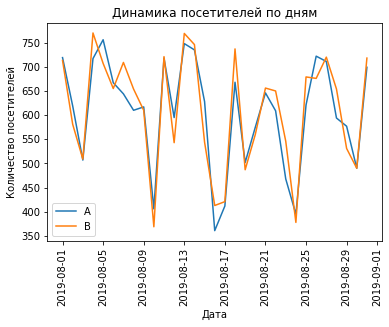

In [19]:
# посмотрим динамику посетителей по дням по группам
a_visitors = visitors[visitors['group'] == 'A']
b_visitors = visitors[visitors['group'] == 'B']

plt.plot(a_visitors['date'], a_visitors['visitors'], label='A')
plt.plot(b_visitors['date'], b_visitors['visitors'], label='B')
plt.legend()
plt.xticks(rotation=90)
plt.title('Динамика посетителей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество посетителей')
plt.show()

Динамика посетителей по дням в обеих группах очень схожа. Количество посетителей резко падает каждую субботу. Можно сказать, что поведение обеих групп одинаковое, что хорошо для объективности результатов A/B теста.

In [20]:
dt.datetime.weekday(dt.datetime(2019,8,3))

5

Пропуски в данных отсутствуют, явных дубликатов нет, данные приведены к типу, позволяющему проводить дальнейшие исследования. Период проведения теста: с 01.08.2019 по 31.08.2019.
58 пользователей попали в обе группы, что говорит о некорректности проведения A/B-теста. Однако удалять их не имеет смысла, так как это также исказит результаты исследования. Исходя из динамики посещений можно сказать, что поведение обеих групп очень схоже.

#### Cбор кумулятивных данных

Необходимо собрать кумулятивные данные. Создадим датафрейм `cumulativeData` со столбцами:  
`date` — дата;  
`group` — группа A/B-теста (A или B);  
`orders` — кумулятивное количество заказов на указанную дату в указанной группе;  
`buyers` — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;  
`revenue` — кумулятивная выручка на указанную дату в указанной группе (средний чек);  
`visitors` — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.  

In [21]:
# создадим массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные данные о заказах по дням
ordersAggregated = (
    datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
                      .agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}),
                      axis=1)
    .sort_values(by=['date','group'])
)

# получаем агрегированные кумулятивные данные о посетителях по дням
visitorsAggregated = (
    datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                      .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}),
                      axis=1)
    .sort_values(by=['date','group'])
)

# объединяем кумулятивные данные в одну таблицу и присвоим понятные названия столбцов
cumulativeData = ordersAggregated.merge(visitorsAggregated, on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head()                      

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [22]:
print(f'cumulativeData \n Начало:{cumulativeData.date.min()}.\n Конец:{cumulativeData.date.max()}')

cumulativeData 
 Начало:2019-08-01 00:00:00.
 Конец:2019-08-31 00:00:00


Минимальная и максимальная даты в датафрейме cumulativeData сопадают с минимальной и максимальной датой в исходных данных.

#### График кумулятивной выручки по группам

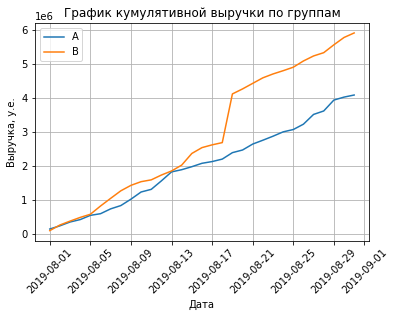

In [23]:
# создадим датафреймы с кумулятивной выручкой и количеством заказов (для дальнейшего расчета среднего чека) по группам
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'orders']]

# построим график кумулятивной выручки по группам
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка, у.е.')
plt.show()

**Вывод:** Исходя из графика кумулятивной выручки можно сказать, что в обеих группах наблюдаются несколько точек, где выручка резко растет. Это может говорить о всплесках числа заказов, либо о появлении аномально дорогих заказов. Следует подробно проанализировать число заказов, а также их стоимость, возможно необходимо избавиться от выбросов.

#### График кумулятивного среднего чека по группам

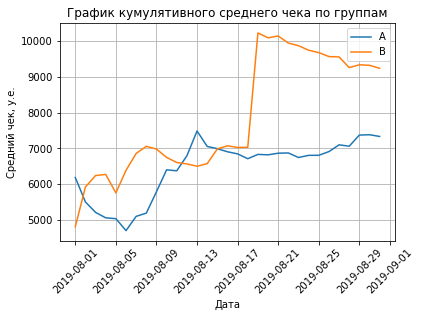

In [24]:
# Посчитаем средний чек разделив выручку на количество заказав и построим график
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек, у.е.')
plt.show()

**Вывод:** График кумулятивного среднего чека показывает резкие скачки в обеих группах, и к концу теста становится более равномерным. Данный график также подтверждает предположение о наличии аномально дорогих заказов, которые сильно завысили средний чек в определенные даты.  

Можно сказать, что средний чек группы `B` также выше, чем в `A`. Однако к концу теста наблюдается небольшое падение среднего чека в `B`, возможно это также связано с выбросами.

#### График относительного изменения кумулятивного среднего чека группы B к группе A

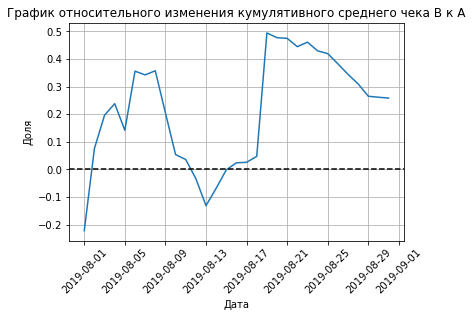

In [25]:
# Необходимо собрать данные в один датафрейм
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, on='date', how='left', suffixes=['A', 'B'])

# Построим график относительного изменения кумулятивного среднего чека группы B к группе A
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB']) / 
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA']) - 1)


plt.xticks(rotation=45)
plt.grid()
plt.title('График относительного изменения кумулятивного среднего чека B к A')
plt.xlabel('Дата')
plt.ylabel('Доля')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

**Вывод:** Исходя из графика относительного изменения кумулятивного среднего чека группы `B` к группе `A`, можно сказать, что наблюдаются резкие скачки, что также подтверждает наличие выбросов. 

Средний чек в группе `B` почти всегда больше, кроме скачка вниз 13-го числа. К концу теста средний чек группы `B` на 25% больше чека группы `A`.

#### График кумулятивного среднего количества заказов на посетителя по группам

Чтобы найти среднее количество заказов на посетителя, надо количество заказов разделить на количество посетителей, это и есть конверсия.

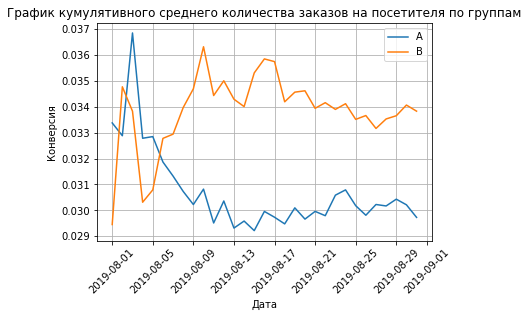

In [26]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группам
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.show()

**Вывод:** Почти сразу конверсия группы `B` вырывается вперед и за все время теста стабильно выше конверсии в группе `A`.

#### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

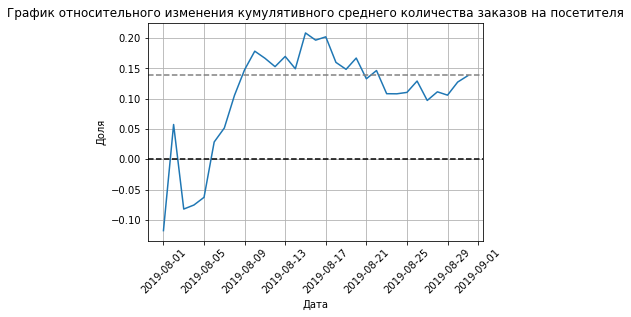

In [27]:
# Необходимо собрать данные в один датафрейм
mergedCumulativeConversions = cumulativeDataA[['date', 'conversion']].merge(cumulativeDataB[['date', 'conversion']], on='date', how='left', suffixes=['A', 'B'])

# Построим график
plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB'] / mergedCumulativeConversions['conversionA'] - 1)

plt.xticks(rotation=45)
plt.grid()
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя')
plt.xlabel('Дата')
plt.ylabel('Доля')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.14, color='grey', linestyle='--')
plt.show()

**Вывод:** В начале теста наблюдается резкий скачок конверсии группы `B` относительно `A`, возможно имеют место выбросы. Затем наблюдается стабильный рост и установление преимущества конверсии группы `B` над группой `A`. Можно сказать, что отношениие конверсии установилось, группа `B` конвертируется на 14% лучше.

#### Точечный график количества заказов по пользователям

In [28]:
# сначала необходимо подсчитать количество заказов по пользователям
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)['transactionId']
    .agg('nunique')
)
ordersByUsers.columns = ['visitorId', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,visitorId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


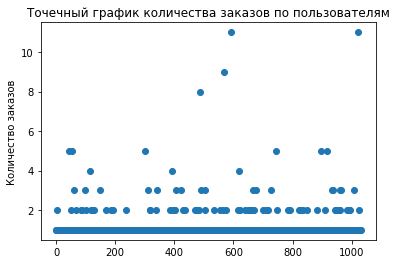

In [29]:
# Построим точечный график
x_values = pd.Series(range(len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечный график количества заказов по пользователям')
plt.ylabel('Количество заказов')
plt.show()

**Вывод:** Подавляющее число пользоватлей делает всего 1-2 заказа, намного реже пользователи делают 3 заказа. Больше 4 заказов встречается очень редко, возможно таких пользователей можно считать аномальными, необходимо изучить подробнее. 

#### Границу для определения аномальных пользователей по количеству заказов

In [30]:
# для опредления границы посчитаем 95-й и 99-й перцентили количества заказов на пользователя
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

**Вывод:** 5% пользователей сделали больше 2 заказов и 1% заказали больше 4 раз. Разумно отсеять пользователей по 99 перцентилю и аномальными считать тех пользователей, кто заказал больше 4 раз.

#### Точечный график стоимостей заказов

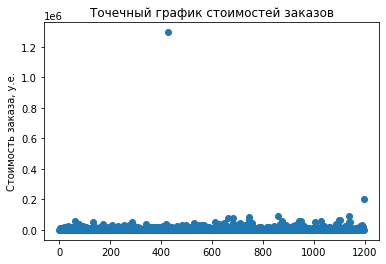

In [31]:
x_values = pd.Series(range(len(orders)))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимостей заказов')
plt.ylabel('Стоимость заказа, у.е.')
plt.show()

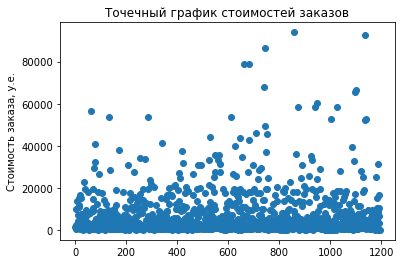

In [32]:
# Из-за аномально дорогих заказов в 1,3 млн у.е. и 202 тыс. у.е. график получился непоказательный
# Ограничим стоимость заказа 200 тыс. у.е.
orders_1 = orders[orders['revenue'] < 200000]
x_values = pd.Series(range(len(orders_1)))
plt.scatter(x_values, orders_1['revenue'])
plt.title('Точечный график стоимостей заказов')
plt.ylabel('Стоимость заказа, у.е.')
plt.show()

**Вывод:** После отсеивания заказов дороже 200 тыс. у.е. точечный график стал информативным. В основном заказы дешеле 20 тыс. у.е., однако точную границу аномально дорогих заказов таким образом определить проблематично.

#### Граница для определения аномальных заказов по стоимости заказов

In [33]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

**Вывод:** 5% заказов дороже 28 тыс. у.е. и 1% дороже 58,2 тыс. у.е. Разумно отсеять пользователей по 99 перцентилю и аномальными считать заказы дороже 58,2 тыс. у.е.

#### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Сформулируем нулевую и альтернативные гипотезы:  
**Н0:** Различий в среднем количестве заказов на посетителя между группами нет.  
**Н1:** Различия в среднем количестве заказов на посетителя между группами есть.  
Критический уровень статистической значимости установим на отметке **0.05**.

In [34]:
# Создадим датафреймы с числом совершенных заказов пользователями по группам
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)['transactionId']
    .agg('nunique')
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)['transactionId']
    .agg('nunique')
)
ordersByUsersB.columns = ['visitorId', 'orders']

In [35]:
# Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов
# Тем, кто ничего не заказал, будут соответствовать нули
sampleA = pd.concat([
    ordersByUsersA['orders'],
    pd.Series(0, index=np.arange(visitors[visitors['group'] == 'A']['visitors'].sum() - len(orders[orders['group'] == 'A'])))
], axis=0)

sampleB = pd.concat([
    ordersByUsersB['orders'],
    pd.Series(0, index=np.arange(visitors[visitors['group'] == 'B']['visitors'].sum() - len(orders[orders['group'] == 'B'])))
], axis=0)

print("p-value: {0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

print("Относительный прирост среднего числа заказов группы B: {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.017
Относительный прирост среднего числа заказов группы B: 0.138


**Вывод:** p-value меньше 0.05, значит, нулевую гипотезу о том, что различий в среднем количестве заказов на посетителя между группами нет, можно отвергнуть в пользу альтернативной. А относительный прирост среднего числа заказов группы `B` составил 13,8%.

#### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем нулевую и альтернативные гипотезы:  
**Н0:** Различий в среднем чеке между группами нет.  
**Н1:** Различия в среднем чеке между группами есть.  
Критический уровень статистической значимости установим на отметке **0.05**.

In [36]:
print('p-value: {0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительный прирост среднего чека группы B:{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.729
Относительный прирост среднего чека группы B:0.259


**Вывод:** p-value значительно больше 0.05, значит отвергнуть нулевую гипотезу нельзя. Наблюдаемые различия не являются статистически значимыми при таком p-value, следовательно различие среднего чека между сегментами в 26% были получены случайно.

#### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

In [37]:
# Определим пользователей с аномальным количесвтом заказов
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['orders'], 99)]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['orders'], 99)]['visitorId'],
    ],
    axis=0,
)

# Определим пользователей  c аномально дорогими заказами
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], 99)]['visitorId']

# Объединим этих пользоватлей как аномальных
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.shape[0])

15


In [38]:
# Всего 15 аномальных пользователя и их надо исключить из sample
sampleA = pd.concat([
    ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
    pd.Series(0, index=np.arange(visitors[visitors['group'] == 'A']['visitors'].sum() - len(orders[orders['group'] == 'A'])))
], axis=0)

sampleB = pd.concat([
    ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
    pd.Series(0, index=np.arange(visitors[visitors['group'] == 'B']['visitors'].sum() - len(orders[orders['group'] == 'B'])))
], axis=0)

print("p-value: {0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

print("Относительный прирост среднего числа заказов группы B: {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.014
Относительный прирост среднего числа заказов группы B: 0.153


**Вывод:** p-value уменьшился и составил 0.014, что меньше 0.05, значит, нулевую гипотезу о том, что различий в среднем количестве заказов на посетителя между группами нет, можно отвергнуть в пользу альтернативной. Относительный прирост среднего числа заказов группы B по "очищенным" данным увеличился и составил 15,3%.

#### Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [39]:
# очиситим sample от аномальных пользователей
sampleAFiltered = orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue']
sampleBFiltered = orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue']

print('p-value: {0:.3f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост среднего чека группы B: {0:.3f}'.format((sampleBFiltered.mean() / sampleAFiltered.mean() - 1)))

p-value: 0.851
Относительный прирост среднего чека группы B: -0.006


**Вывод:** p-value всё еще значительно больше 0.05, значит отвергнуть нулевую гипотезу нельзя. Как и нельзя считать, что различия в среднем чеке между группами есть. Относительный прирост среднего чека группы изменился и составил всего -0,6% (т.е. средний чек группы B совем немного меньше А). Что говорит о верном исключении аномалий.

## Вывод

В результате проведенного исследования мы выполнили ряд задач.

Прежде всего были приоритизировать гипотезы по увеличению выручки интернет-магазина с применением фреймворка ICE и фреймворка RICE для приоритизации гипотез. Приоритизация гипотез при применении RICE вместо ICE значительно именилась, это можно объяснить применением критерия Reach. Кроме силы гипотез, в RICE мы учитываем как много пользователей она затронет.  
В результате для проведения A/B-теста была выбрана гипотеза №8, именно она является наиболее перспективной, затронет наибольшее число пользователей и будет иметь сильное влияние на пользователей, их опыт и удовлетворение от продукта:  

***Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.***

Далее мы запустили A/B-тест и проанализировали результаты.  
Выводы по тесту сделаны следующие:
1. Статистически значимые различия по среднему количеству заказов между группами есть. Это прослеживается и по "сырым" данным, и по данным после фильтрации аномалий. Относительный прирост среднего числа заказов группы `B` составил:  
13,8% по "сырым" данным;  
15,3% по "очищенным" данным.


2. Статистически значимого различия по среднему чеку между группами нет ни по «сырым», ни по данным после фильтрации аномалий.

3. График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A показал, что группа `B` стабильно конвертируется лучше группы `A`.

4. После исключения аномальных пользователей средний чек группы `B` оказался на 0,6% меньше чека группы `B`, что также говорит об отсутствии значимых различий между средними чеками групп.

На основании вышеизложенных фактов по результату A/B-теста принято следующее решение:  
Остановить тест, зафиксировать победу группы `B` и и считать гипотезу по увеличению выручки интернет-магазина успешной.